# XAI Programming Assignment 2
GradCAM on time series

In [1]:
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 11.7 MB/s eta 0:00:00


In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from aeon.datasets import load_classification
from sklearn.metrics import accuracy_score

# Example 1
## Model preparation
We work on the GunPoint dataset, which describes the movement of hands when a person holds a gun or just points with a finger. https://www.timeseriesclassification.com/description.php?Dataset=GunPoint

In [2]:
X, y = load_classification("GunPoint")
print(" Shape of X = ", X.shape)

 Shape of X =  (200, 1, 150)


In [3]:
y[y=='2'] = '0'
y = y.astype(int)

I changed labeling such that '1' <=> person holds a gun

In [4]:
X_train = X[:50]
X_test = X[50:]
y_train = y[:50]
y_test = y[50:]

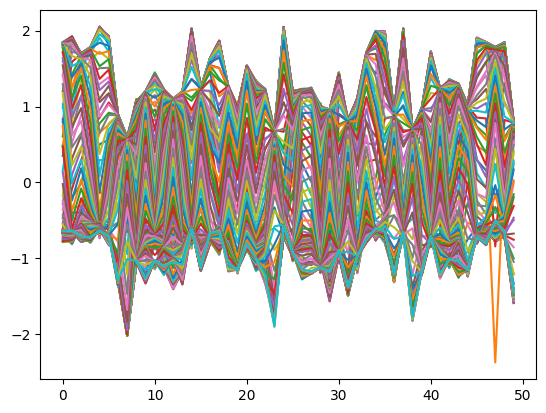

In [5]:
plt.plot(X_train.squeeze());

I don't scale the input for the sake of better interpretability

### Model training
I use generic convolutional neural network model based on https://keras.io/examples/timeseries/timeseries_classification_from_scratch/ with minor improvements

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model = make_model(input_shape=X_train.shape[1:])

In [ ]:
epochs = 100
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5a", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)
model.summary()

Epoch 1/100
5/5 [==============================] - 5s 656ms/step - loss: 0.2649 - binary_accuracy: 0.9250 - val_loss: 0.7470 - val_binary_accuracy: 0.7000 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 1s 357ms/step - loss: 0.2428 - binary_accuracy: 0.9500 - val_loss: 0.6762 - val_binary_accuracy: 0.7000 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 1s 362ms/step - loss: 0.2405 - binary_accuracy: 0.9750 - val_loss: 0.6691 - val_binary_accuracy: 0.7000 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 1s 358ms/step - loss: 0.2352 - binary_accuracy: 0.9500 - val_loss: 0.6556 - val_binary_accuracy: 0.7000 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 1s 363ms/step - loss: 0.2947 - binary_accuracy: 0.9000 - val_loss: 0.6163 - val_binary_accuracy: 0.7000 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 2s 470ms/step - loss: 0.1858 - binary_accuracy: 1.0000 - val_loss: 0.5704 - val_binary_accuracy: 0.7000 - lr:

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

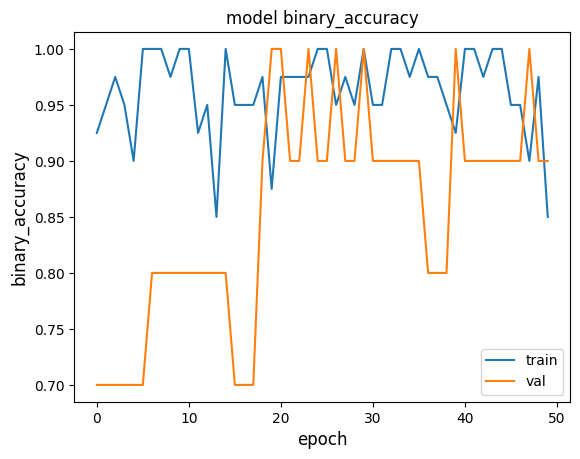

In [ ]:
metric = "binary_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

This models seems to be pretty good. ACC on test dataset is almost 90%

In [ ]:
result = np.zeros_like(y_test)
result[model.predict(X_test).squeeze() > 0.5] = 1
accuracy_score(result, y_test)

5/5 [==============================] - 0s 3ms/step


0.8933333333333333

I save and download the model from Google Collab environment

In [ ]:
# model compression for collab to enable downloading
!zip -r best_model.zip best_model.h5a

  adding: best_model.h5a/ (stored 0%)
  adding: best_model.h5a/variables/ (stored 0%)
  adding: best_model.h5a/variables/variables.data-00000-of-00001 (deflated 53%)
  adding: best_model.h5a/variables/variables.index (deflated 69%)
  adding: best_model.h5a/keras_metadata.pb (deflated 92%)
  adding: best_model.h5a/saved_model.pb (deflated 89%)
  adding: best_model.h5a/assets/ (stored 0%)
  adding: best_model.h5a/fingerprint.pb (stored 0%)


### Loading pretrained model
Model was trained in the previous section

In [6]:
!unzip best_model.zip

Archive:  best_model.zip
   creating: best_model.h5a/
   creating: best_model.h5a/variables/
  inflating: best_model.h5a/variables/variables.data-00000-of-00001  
  inflating: best_model.h5a/variables/variables.index  
  inflating: best_model.h5a/keras_metadata.pb  
  inflating: best_model.h5a/saved_model.pb  
   creating: best_model.h5a/assets/
 extracting: best_model.h5a/fingerprint.pb  


In [7]:
# Recreate the exact same model, including its weights and the optimizer
model = keras.models.load_model('best_model.h5a')

# Show the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 150)]          0         
                                                                 
 conv1d (Conv1D)             (None, 1, 8)              3608      
                                                                 
 batch_normalization (Batch  (None, 1, 8)              32        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 1, 8)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 8)              200       
                                                                 
 batch_normalization_1 (Bat  (None, 1, 8)              32        
 chNormalization)                                            

In [8]:
result = np.zeros_like(y_test)
result[model.predict(X_test).squeeze() > 0.5] = 1
accuracy_score(result, y_test)

5/5 [==============================] - 1s 21ms/step


0.8866666666666667

Although it is not exactly the same model as the pretrained one (because of save best only flag), the model still has pretty good accuracy.

## Model explanation
I will make use of the `tf-explain` package which provides GradCAM implementation and visualisation for images. It should be possible to calculate mask using this package and visualize it independently.

In [13]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00


In [9]:
# Import explainer
from tf_explain.core.grad_cam import GradCAM
import cv2

`tf-explain` calculates a mask and returns it in a selected colormap in RGB format. Because in time series we have only one channel, I use simple grayscale colormap.

In [10]:
# Instantiation of the explainer
explainer = GradCAM()

In [11]:
X_train.shape

(50, 1, 150)

/usr/local/lib/python3.10/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


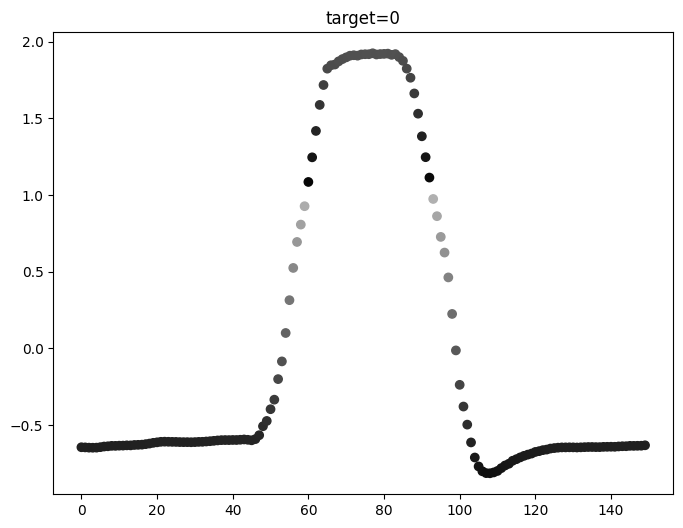

In [12]:
idx = 1 # index to explain <150
data = X_train[[idx]]
target = y_train[idx]


# Call to explain() method
output = explainer.explain((data, target), model, 0, 're_lu_2', colormap=cv2.COLORMAP_BONE)

# Output values need to be scaled to (0, 1) range
colors = output/255
colors = colors.squeeze()

fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(data.squeeze())
ax.scatter(np.arange(len(output.squeeze())), data.squeeze(), c=colors)
ax.set_title(f'target={target}')
plt.show()

Raw output plotting (it might be appropriate for comparisons between instances, because it is not normalized for each series)

In [13]:
from matplotlib.collections import LineCollection

In [17]:
# Does the choice of within the last layer (conv/activation) changes anything?
idx = 27 # index to explain 1 or 27
data = X_train[[idx]]
target = y_train[idx]


# Call to explain() method
output = explainer.explain((data, target), model, 0, 'conv1d_2', colormap=cv2.COLORMAP_BONE)

# Output values need to be scaled to (0, 1) range
colors = output/255
colors = colors.squeeze()

# fig, ax = plt.subplots(figsize=(8, 6))
# # ax.plot(data.squeeze())
# ax.scatter(np.arange(len(output.squeeze())), data.squeeze(), c=colors)
# ax.set_title(f'target={target}')
# plt.show()

/usr/local/lib/python3.10/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


1/1 [==============================] - 0s 25ms/step


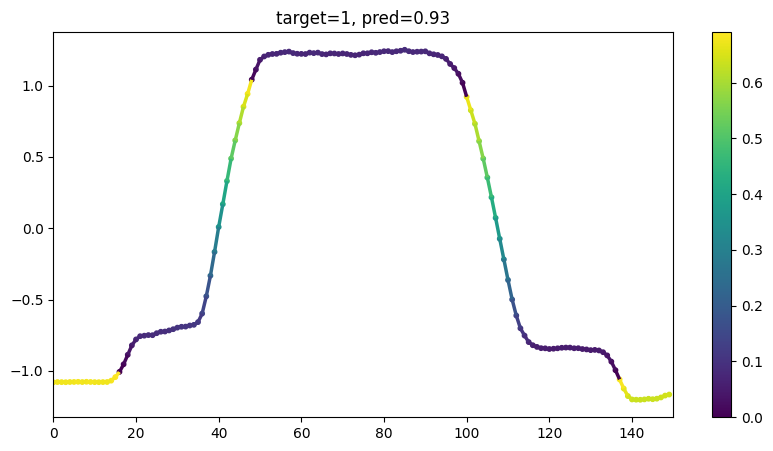

In [18]:
points = np.array([np.arange(len(data.squeeze())), data.squeeze()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='viridis')#, norm=norm)
lc.set_array(colors[:-1, 0])
lc.set_linewidth(2.5)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, len(points))
offset = 0.05*(data.max() - data.min())
ax.set_ylim(data.min()-offset, data.max()+offset)
ax.add_collection(lc)
ax.scatter(points[:, :, 0], points[:, :, 1], c=colors[:, 0], s=10)
fig.colorbar(lc)
ax.set_title(f'target={target}, pred={model.predict(data)[0, 0]:.2f}')
plt.savefig('model_1_target_1_ex.png')
plt.show()

# Example 2
Initially, I planned to work on 'HeartBeat' dataset, but I couldn't train a model on it. Eventually, I switched data to https://www.timeseriesclassification.com/description.php?Dataset=Yoga

In [19]:
X, y = load_classification("Yoga")
# y = y.astype(int)
print(" Shape of X = ", X.shape)

 Shape of X =  (3300, 1, 426)


In [20]:
y[y=='2'] = '0'
y = y.astype(int)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1234, shuffle=True, stratify=y_train)

In [23]:
1-y_test.sum()/len(y_test) # if we use dummy classifier returning always 0 we will get 73%

0.5363636363636364

In [24]:
X_train.shape

(1485, 1, 426)

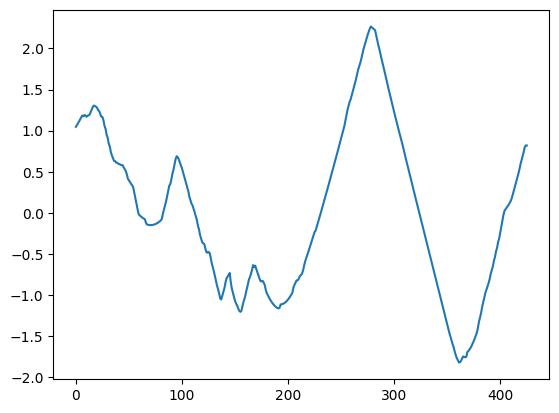

In [25]:
plt.plot(X_train[0].squeeze())

## Model training

In [146]:
def make_model2(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=8, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    # conv1 = keras.layers.MaxPooling1D(pool_size=2, padding="same")(conv1)

    conv2 = keras.layers.Conv1D(filters=8, kernel_size=5, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv2 = keras.layers.Conv1D(filters=8, kernel_size=7, padding="same")(conv2)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    gap = keras.layers.GlobalAveragePooling1D()(conv2)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [147]:
model = make_model2(input_shape=X_train.shape[1:])

In [148]:
epochs = 100
batch_size = 16

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.h5a", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 1, 426)]          0         
                                                                 
 conv1d_60 (Conv1D)          (None, 1, 8)              10232     
                                                                 
 batch_normalization_58 (Ba  (None, 1, 8)              32        
 tchNormalization)                                               
                                                                 
 re_lu_58 (ReLU)             (None, 1, 8)              0         
                                                                 
 conv1d_61 (Conv1D)          (None, 1, 8)              328       
                                                                 
 batch_normalization_59 (Ba  (None, 1, 8)              32        
 tchNormalization)                                        

In [149]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/100
93/93 [==============================] - 6s 33ms/step - loss: 0.6628 - binary_accuracy: 0.5966 - val_loss: 0.6924 - val_binary_accuracy: 0.5636 - lr: 0.0010
Epoch 2/100
93/93 [==============================] - 3s 33ms/step - loss: 0.5945 - binary_accuracy: 0.7037 - val_loss: 0.6643 - val_binary_accuracy: 0.6061 - lr: 0.0010
Epoch 3/100
93/93 [==============================] - 2s 27ms/step - loss: 0.5744 - binary_accuracy: 0.7104 - val_loss: 0.6388 - val_binary_accuracy: 0.6606 - lr: 0.0010
Epoch 4/100
93/93 [==============================] - 54s 591ms/step - loss: 0.5426 - binary_accuracy: 0.7340 - val_loss: 0.5632 - val_binary_accuracy: 0.7333 - lr: 0.0010
Epoch 5/100
93/93 [==============================] - 2s 27ms/step - loss: 0.5142 - binary_accuracy: 0.7576 - val_loss: 0.5198 - val_binary_accuracy: 0.7212 - lr: 0.0010
Epoch 6/100
93/93 [==============================] - 1s 9ms/step - loss: 0.5247 - binary_accuracy: 0.7576 - val_loss: 0.5742 - val_binary_accuracy: 0.678

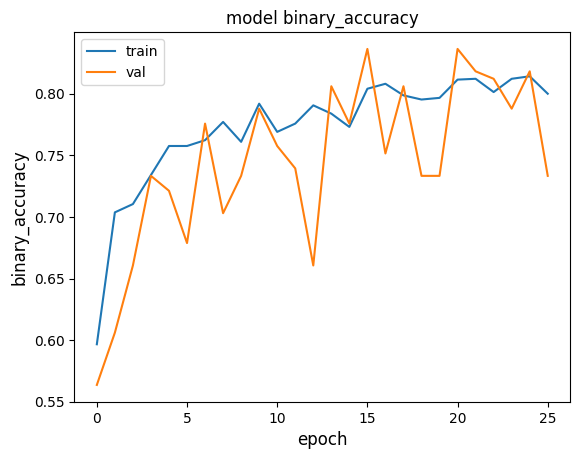

In [150]:
metric = "binary_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

In [151]:
# model compression for collab to enable downloading
!zip -r best_model2.zip best_model2.h5a

  adding: best_model2.h5a/ (stored 0%)
  adding: best_model2.h5a/saved_model.pb (deflated 89%)
  adding: best_model2.h5a/variables/ (stored 0%)
  adding: best_model2.h5a/variables/variables.index (deflated 68%)
  adding: best_model2.h5a/variables/variables.data-00000-of-00001 (deflated 52%)
  adding: best_model2.h5a/assets/ (stored 0%)
  adding: best_model2.h5a/fingerprint.pb (stored 0%)
  adding: best_model2.h5a/keras_metadata.pb (deflated 92%)


## Loading pretrained model

In [ ]:
!unzip best_model2.zip

In [26]:
# Recreate the exact same model, including its weights and the optimizer
model = keras.models.load_model('best_model2.h5a')

# Show the model architecture
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 1, 426)]          0         
                                                                 
 conv1d_60 (Conv1D)          (None, 1, 8)              10232     
                                                                 
 batch_normalization_58 (Ba  (None, 1, 8)              32        
 tchNormalization)                                               
                                                                 
 re_lu_58 (ReLU)             (None, 1, 8)              0         
                                                                 
 conv1d_61 (Conv1D)          (None, 1, 8)              328       
                                                                 
 batch_normalization_59 (Ba  (None, 1, 8)              32        
 tchNormalization)                                        

In [27]:
result = np.zeros_like(y_test)
result[model.predict(X_test).squeeze() > 0.5] = 1
accuracy_score(result, y_test)

52/52 [==============================] - 1s 6ms/step


0.8539393939393939

## Model explanation

In [28]:
# Instantiation of the explainer
explainer = GradCAM()

/usr/local/lib/python3.10/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


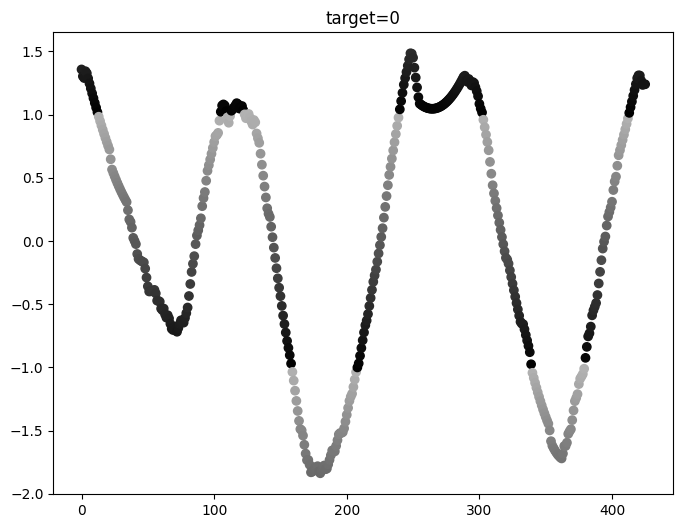

In [29]:
idx = 1 # index to explain
data = X_train[[idx]]
target = y_train[idx]


# Call to explain() method
output = explainer.explain((data, target), model, 0, 're_lu_60', colormap=cv2.COLORMAP_BONE)

# Output values need to be scaled to (0, 1) range
colors = output/255
colors = colors.squeeze()

fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(data.squeeze())
ax.scatter(np.arange(len(output.squeeze())), data.squeeze(), c=colors)
ax.set_title(f'target={target}')
plt.show()

In [32]:
# Does the choice of within the last layer (conv/activation) changes anything?
idx = 1 # index to explain e.g. 1 or 23
data = X_train[[idx]]
target = y_train[idx]


# Call to explain() method
output = explainer.explain((data, target), model, 0, 'conv1d_62', colormap=cv2.COLORMAP_BONE)

# Output values need to be scaled to (0, 1) range
colors = output/255
colors = colors.squeeze()

# fig, ax = plt.subplots(figsize=(8, 6))
# # ax.plot(data.squeeze())
# ax.scatter(np.arange(len(output.squeeze())), data.squeeze(), c=colors)
# ax.set_title(f'target={target}')
# plt.show()

1/1 [==============================] - 0s 118ms/step


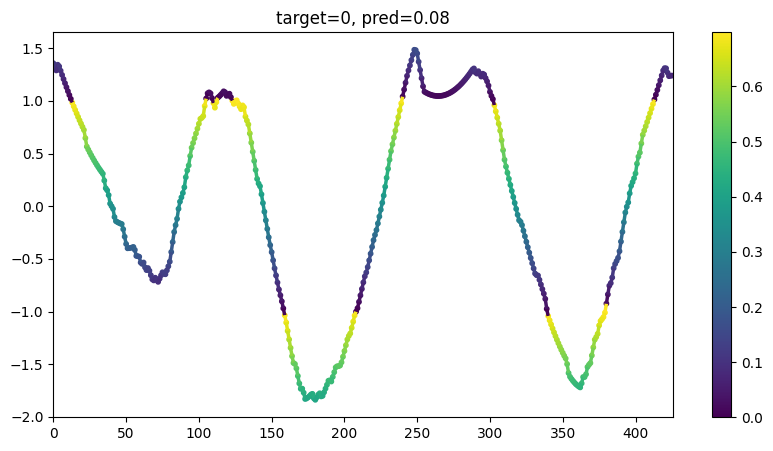

In [33]:
points = np.array([np.arange(len(data.squeeze())), data.squeeze()]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='viridis')#, norm=norm)
lc.set_array(colors[:-1, 0])
lc.set_linewidth(2.5)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(0, len(points))
offset = 0.05*(data.max() - data.min())
ax.set_ylim(data.min()-offset, data.max()+offset)
ax.add_collection(lc)
ax.scatter(points[:, :, 0], points[:, :, 1], c=colors[:, 0], s=10)
fig.colorbar(lc)
ax.set_title(f'target={target}, pred={model.predict(data)[0, 0]:.2f}')
plt.savefig('model_2_target_0.png')
plt.show()